# This Week. Files shall be uploaded, User Queries Shall be Answered and The API Key Will hopefully NOT Run Out.


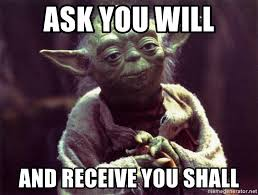

# The API Model will be in another notebook cuz this one ran after a struggle, so i will not temper with it

In [1]:
!pip install -q fastapi uvicorn nest_asyncio python-multipart transformers sentence-transformers langchain faiss-cpu

# The Model in Here is FLAN-T5 Because for the sake of the task and the for my sanity working with this model as annoying as it is. it is at least familiar 

In [2]:
import nest_asyncio
from fastapi import FastAPI, UploadFile, File
from fastapi.responses import JSONResponse
from fastapi.middleware.cors import CORSMiddleware
import uvicorn
import pandas as pd
from transformers import pipeline
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.docstore.document import Document
import io

nest_asyncio.apply()

app = FastAPI(title="LLM Q&A API with File Upload")

app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

vectorstore = None
qa_pipeline = pipeline("text2text-generation", model="google/flan-t5-base")
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

Device set to use cpu
C:\Users\mahmoud.alameen\AppData\Local\Temp\ipykernel_2184\2444274.py:27: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


# for some reason everytime i uploaded the file it would not except lists or anytype of conversion. texts worked but when i did it the first time it was tailored to the file infos. so to enable the user to upload their own files i used a method that makes them into documents

In [3]:
@app.post("/upload")
async def upload_file(file: UploadFile = File(...)):
    global vectorstore
    ext = file.filename.split('.')[-1]
    

    content = await file.read()
    if ext == "csv":
        df = pd.read_csv(io.BytesIO(content))
    elif ext in ["xlsx", "xls"]:
        df = pd.read_excel(io.BytesIO(content))
    elif ext == "json":
        df = pd.read_json(io.BytesIO(content))
    else:
        return JSONResponse(status_code=400, content={"error": "Unsupported file type"})
    
    docs = []
    for i, row in df.iterrows():
        text = " | ".join([str(x) for x in row if pd.notna(x)])
        docs.append(Document(page_content=text))

    vectorstore = FAISS.from_documents(docs, embedding_model)
    return {"status": "File uploaded and vectorstore built", "rows": len(docs)}

# i tried with multiple 'k' values and anything higher than 3 just wouldnt work. either it will just crash or will give a.....not so logical answer

In [4]:
@app.get("/ask")
async def ask_question(query: str):
    global vectorstore
    if vectorstore is None:
        return JSONResponse(status_code=400, content={"error": "Upload data first"})

    docs = vectorstore.similarity_search(query, k=3)
    context = "\n".join([doc.page_content for doc in docs])

    prompt = f"Context: {context}\n\nQuestion: {query}\nAnswer:"
    result = qa_pipeline(prompt, max_new_tokens=150)[0]["generated_text"]
    
    return {"query": query, "answer": result.strip()}

In [ ]:
import threading
import time
from fastapi import FastAPI
import uvicorn

def run_app():
    uvicorn.run(app, host="127.0.0.1", port=8000)

thread = threading.Thread(target=run_app)
thread.start()

time.sleep(2)

print("FastAPI is running! You can access the API at:")
print("http://127.0.0.1:8000/docs")

INFO:     Started server process [2184]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


FastAPI is running! You can access the API at:
http://127.0.0.1:8000/docs


INFO:     127.0.0.1:59580 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:59580 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:59633 - "POST /upload HTTP/1.1" 200 OK


Token indices sequence length is longer than the specified maximum sequence length for this model (622 > 512). Running this sequence through the model will result in indexing errors


INFO:     127.0.0.1:59746 - "GET /ask?query=what%20anime%20has%20the%20best%20score HTTP/1.1" 200 OK
INFO:     127.0.0.1:59749 - "GET /ask?query=what%20is%20the%20score%20of%20Naruto HTTP/1.1" 200 OK
INFO:     127.0.0.1:59754 - "GET /ask?query=how%20many%20episodes%20does%20naruto%20have HTTP/1.1" 200 OK
INFO:     127.0.0.1:59755 - "GET /ask?query=how%20many%20episodes%20naruto HTTP/1.1" 200 OK
INFO:     127.0.0.1:59760 - "GET /ask?query=naruto HTTP/1.1" 200 OK
INFO:     127.0.0.1:59764 - "GET /ask?query=konohagakure HTTP/1.1" 200 OK
INFO:     127.0.0.1:59765 - "GET /ask?query=frieren HTTP/1.1" 200 OK
INFO:     127.0.0.1:59766 - "GET /ask?query=what%20is%20the%20score%20of%20frieren HTTP/1.1" 200 OK
INFO:     127.0.0.1:59779 - "GET /ask?query=what%20is%20the%20score%20of%20the%20apothecary%20diaries%20 HTTP/1.1" 200 OK
INFO:     127.0.0.1:59820 - "GET /ask?query=what%20is%20the%20score%20of%20kusuriya%20no%20hitorigoto HTTP/1.1" 200 OK
INFO:     127.0.0.1:59932 - "GET /ask?query=what%2

# Results

for testing this i used a csv file qurated from the my anime list website because.....yes. 

the model is a bit confused but on the right track, showing the ability to distinguish between simillar things like naruto and naruto shippuden as well as getting stuff like production studio (the one between the ||)

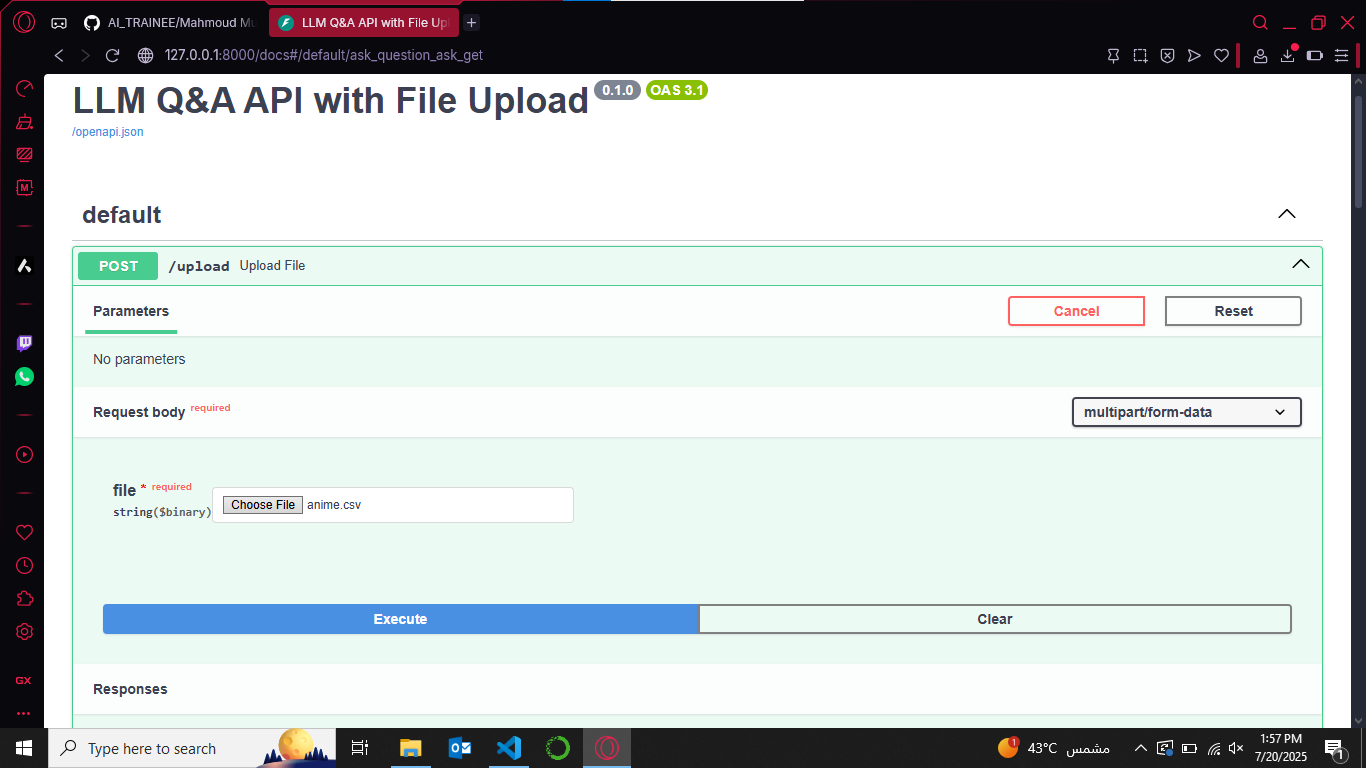

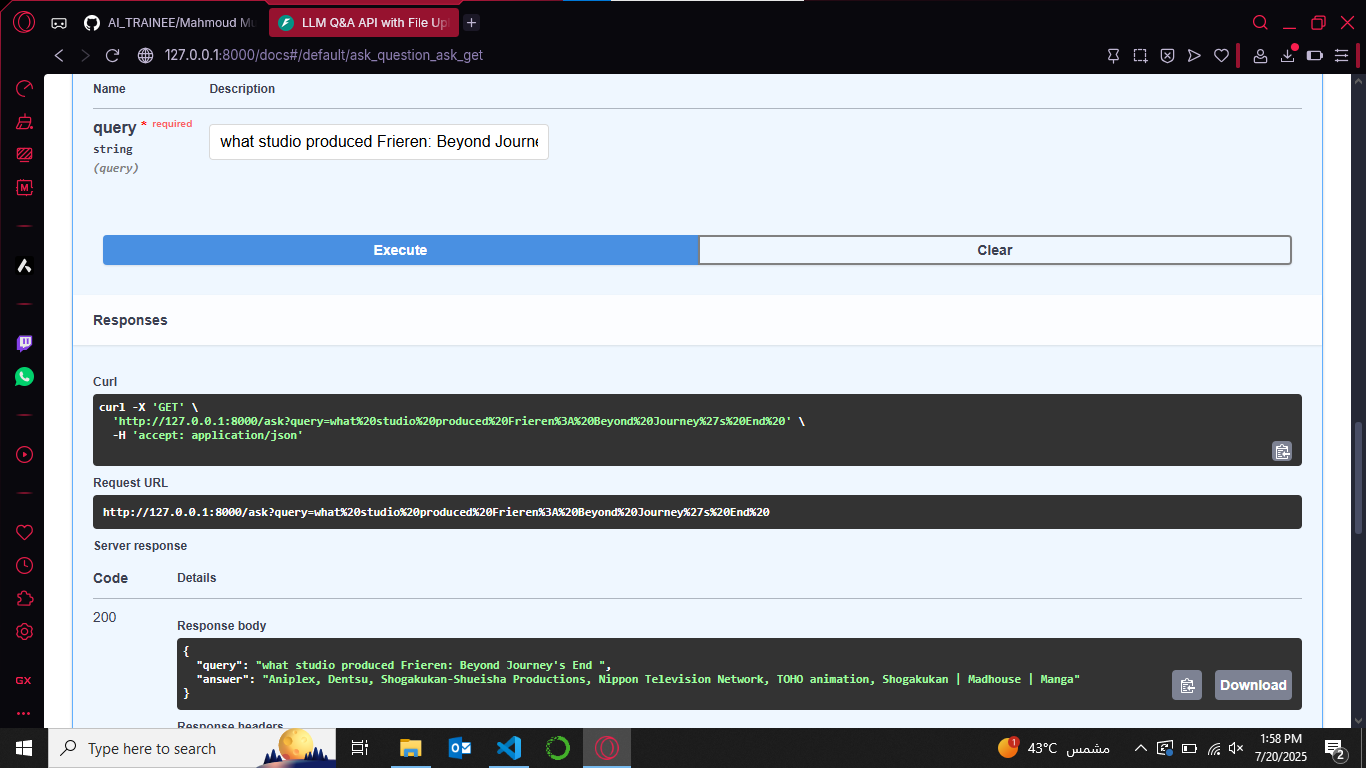

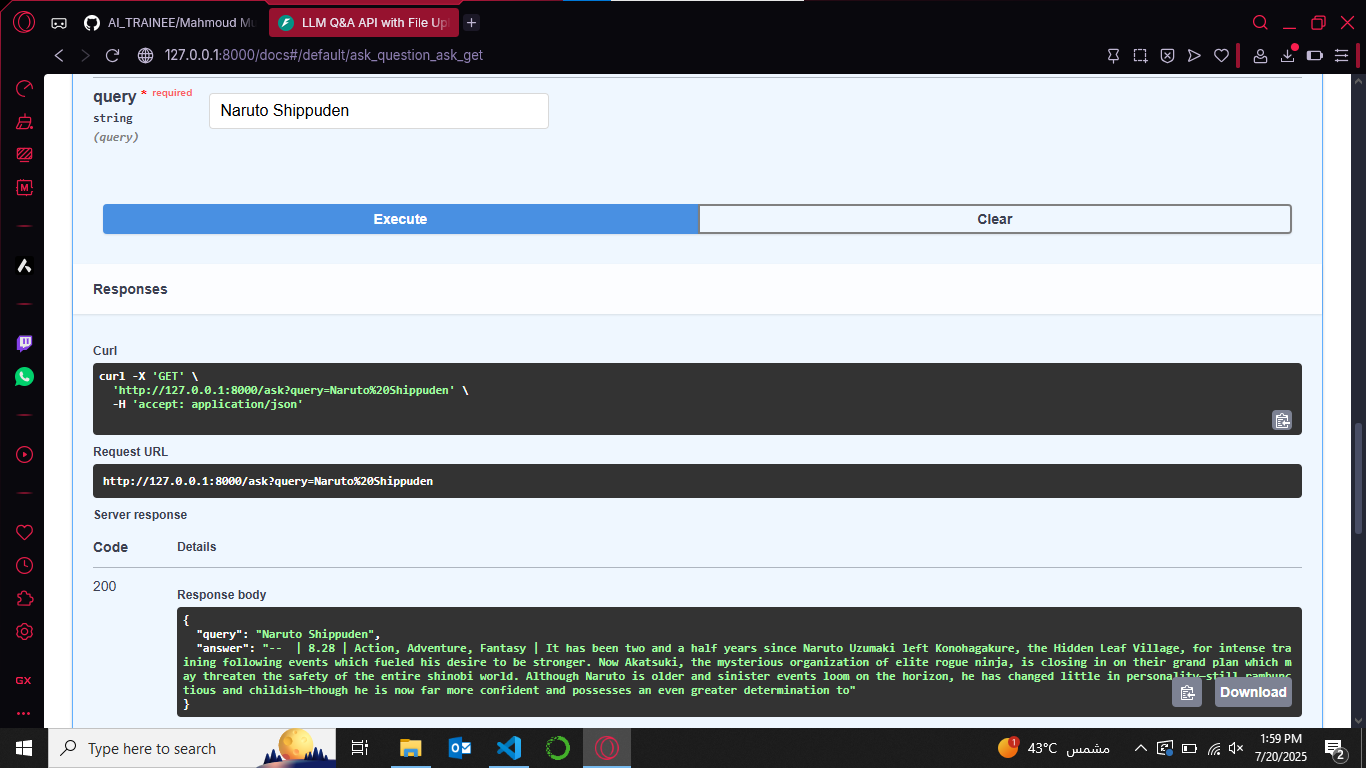

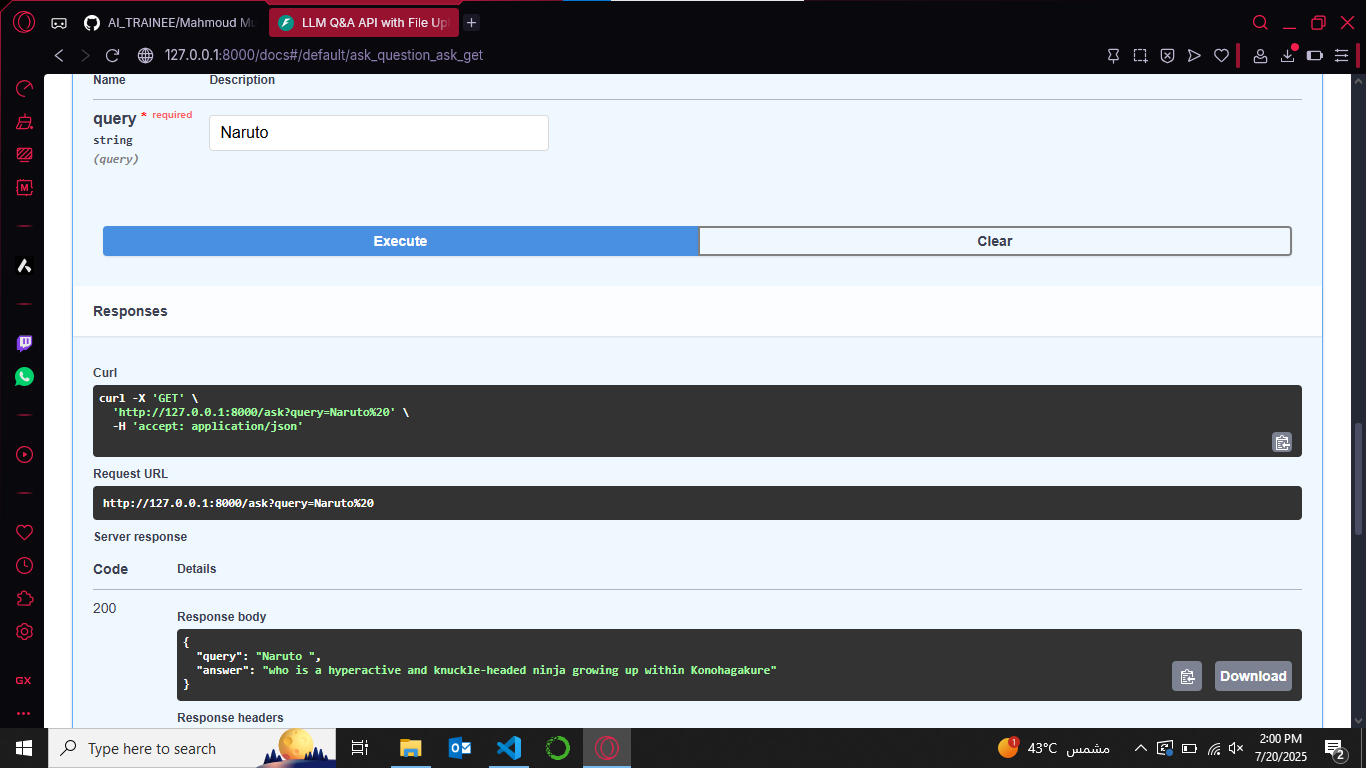